In [46]:
import numpy as np
import numpy
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from nbodykit.cosmology import Cosmology, EHPower, Planck15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import tensorflow as tf
# tf.enable_eager_execution()

In [48]:
sys.path.append('../code/utils/')
import tools
from background import *
from tfpm import *
from tfpmfuncs import *
from fpmfuncs import *
from fpm import *
from pmconfig import Config


In [49]:
state = fastpm()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Step F 0.1000 - (0.1000) -> 0.1000 S 0.1000 P 0.1000 F 0.1000
Step K 0.1000 - (0.1000) -> 0.1803 S 0.1000 P 0.1803 F 0.1000
Step D 0.1000 - (0.1803) -> 0.3250 S 0.3250 P 0.1803 F 0.1000
Step F 0.1000 - (0.3250) -> 0.3250 S 0.3250 P 0.1803 F 0.3250
Step K 0.1803 - (0.3250) -> 0.3250 S 0.3250 P 0.3250 F 0.3250
Step K 0.3250 - (0.3250) -> 0.4228 S 0.3250 P 0.4228 F 0.3250
Step D 0.3250 - (0.4228) -> 0.5500 S 0.5500 P 0.4228 F 0.3250
Step F 0.3250 - (0.5500) -> 0.5500 S 0.5500 P 0.4228 F 0.5500
Step K 0.4228 - (0.5500) -> 0.5500 S 0.5500 P 0.5500 F 0.5500
Step K 0.5500 - (0.5500) -> 0.6529 S 0.5500 P 0.6529 F 0.5500
Step D 0.5500 - (0.6529) -> 0.7750 S 0.7750 P 0.6529 F 0.5500
Step F 0.5500 - (0.7750) -> 0.7750 S 0.7750 P 0.6529 F 0.7750
Step K 0.6529 - (0.7750) -> 0.7750 S 0.7750 P 0.7750 F 0.7750
Step K 0.7750 - (0.7750) -> 0.8803 S 0.7750 P 0.8803 F 0.7750
Step D 0.7750 - (0.8803) -> 1.0000 S 1.0000 P 0.8803 F 0.7750
Step F 0.7750 - (1.0000) -> 1.0000 S 1.0000 P 0.8803 F 1.0000
Step K 0

# Check lptz0

In [50]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32, symmetric=False)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: mode argument is deprecated, use type


In [51]:
lptdisp = lptz0(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)


In [52]:
# #
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
print(tlptmesh, tlptpos)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos, tflptmesh = sess.run([tlptpos, tlptmesh])

Tensor("zeros_like_30:0", shape=(8, 8, 8), dtype=float32) Tensor("Add_581:0", shape=(512, 3), dtype=float32)


In [53]:
tflptpos-lptpos

array([[ 2.9802322e-07, -5.9604645e-07, -4.7683716e-07],
       [ 3.2782555e-07,  0.0000000e+00,  0.0000000e+00],
       [ 1.1920929e-07, -8.1956387e-08,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Text(0.5,1,'Yu 2LPT')

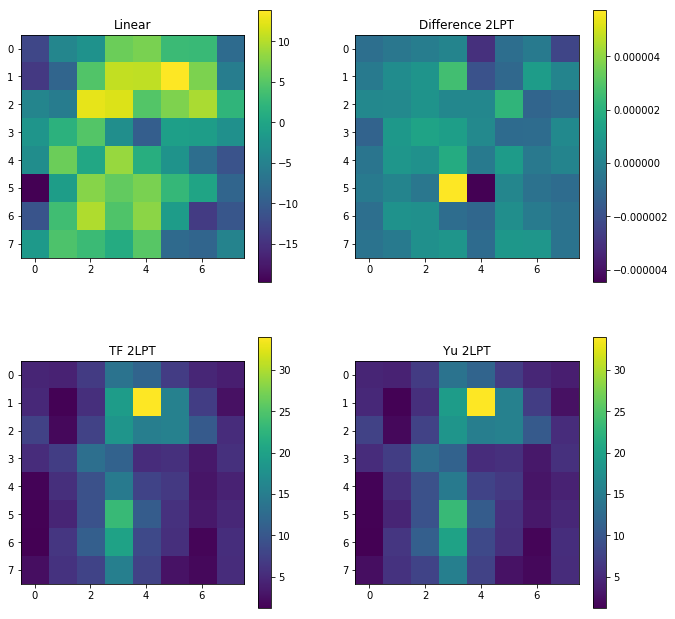

In [54]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))
ax = axar[0]
im = ax[0].imshow(linear[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Linear')
im = ax[1].imshow((lptmesh-tflptmesh)[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Difference 2LPT')
ax = axar[1]
im = ax[0].imshow(tflptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF 2LPT')
im = ax[1].imshow(lptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu 2LPT')



#### Checkgrad

In [25]:
gindex = [0, 1, 1]
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
print(tlptmesh, tlptpos)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)
grad = tf.gradients(tlptmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tflptpos, tflptmesh = sess.run([grad, tlptpos, tlptmesh])

Tensor("zeros_like_22:0", shape=(8, 8, 8), dtype=float32) Tensor("Add_422:0", shape=(512, 3), dtype=float32)


In [26]:
# #
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)
grad = tf.gradients(tlptmesh, tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos2, tflptmesh2 = sess.run([tlptpos, tlptmesh])

In [32]:
(tflptmesh2 - tflptmesh)[tuple(gindex)]/dx, tgrad[0][tuple(index)]

(0.005969218909740448, 0.0059663057)

# FastPM

In [55]:
a0, a1 = conf['stages'][0], conf['stages'][1]
ah = (a0*a1)**0.5

### lpt IC

In [56]:
# #
statelpt = solver.lpt(lineark, grid, a0, order=2)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstatelpt = sess.run(tflptic)
# tfstatelpt = ttmp.copy()

In [57]:
(tfstatelpt[0])/ statelpt.X

array([[0.9999983 , 1.0000004 , 0.99999976],
       [0.9999993 , 1.0000001 , 1.        ],
       [0.99999994, 1.0000008 , 1.        ],
       ...,
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        ]], dtype=float32)

In [58]:
(tfstatelpt[0]-grid)/ statelpt.S

array([[0.9999983 , 1.0000004 , 0.99999976],
       [0.9999993 , 1.0000001 , 1.0000001 ],
       [0.99999994, 1.0000008 , 1.0000002 ],
       ...,
       [1.0000025 , 0.9999933 , 1.0000007 ],
       [0.9999989 , 0.99999285, 0.9999994 ],
       [0.9999323 , 0.999978  , 1.0000008 ]], dtype=float32)

In [59]:
(tfstatelpt[1])/ statelpt.V, (tfstatelpt[1])/ statelpt.P

(array([[0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001],
        ...,
        [0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001],
        [0.001, 0.001, 0.001]], dtype=float32),
 array([[0.99999845, 1.0000004 , 0.99999976],
        [0.9999992 , 1.        , 1.        ],
        [0.9999999 , 1.0000012 , 1.        ],
        ...,
        [1.0000004 , 1.0000005 , 0.99999994],
        [0.9999999 , 1.        , 1.        ],
        [1.0000004 , 1.0000006 , 1.0000006 ]], dtype=float32))

In [60]:
(tfstatelpt[2])/ statelpt.F

array([[0.99999857, 1.0000005 , 0.99999976],
       [0.99999934, 1.        , 1.        ],
       [0.99999994, 1.0000018 , 1.0000001 ],
       ...,
       [1.0000004 , 1.0000005 , 1.        ],
       [1.        , 0.9999999 , 1.        ],
       [1.0000004 , 1.0000006 , 1.0000006 ]], dtype=float32)

### Kick

In [91]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['F'] = ah
solver.nbodystep.Kick(state, a0, ah, a1)

##
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

Tensor("Const_604:0", shape=(1,), dtype=int32)
Tensor("Mul_551:0", shape=(512, 3), dtype=float32)
Tensor("Const_605:0", shape=(3,), dtype=int32)


InvalidArgumentError: The outermost dimension of updates and indices must match. Got indices.shape [1], updates.shape [512,3]
	 [[{{node ScatterNd_28}} = ScatterNd[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const_604, Mul_551, Const_605)]]

Caused by op 'ScatterNd_28', defined at:
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-70cd671af47f>", line 8, in <module>
    tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
  File "../code/utils/tfpm.py", line 185, in tfKick
    update = tf.scatter_nd(indices, update, shape)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6891, in scatter_nd
    "ScatterNd", indices=indices, updates=updates, shape=shape, name=name)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): The outermost dimension of updates and indices must match. Got indices.shape [1], updates.shape [512,3]
	 [[{{node ScatterNd_28}} = ScatterNd[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Const_604, Mul_551, Const_605)]]


In [80]:
ii = 1
tfstate[ii] / tfstatelpt[ii], 
tfstate[ii] / state.P

array([[0.25697407, 0.28454182, 0.27124715],
       [0.27584362, 0.2760695 , 0.27805188],
       [0.27731335, 0.36175668, 0.27752393],
       ...,
       [0.28098473, 0.27297422, 0.27587658],
       [0.27997956, 0.2731709 , 0.2748157 ],
       [0.2738682 , 0.29955018, 0.27262908]], dtype=float32)

#### Checkgrad

In [44]:
tfstate.shape

(3, 512, 3)

In [42]:
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
grad = tf.gradients(tfkicked, tfstate)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tfstate = sess.run([grad, tfkicked])

TypeError: Fetch argument None has invalid type <class 'NoneType'>

### Drift

In [19]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [20]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['P'] = ah
solver.nbodystep.Drift(state, a0, ah, a1)

# #
tfkicked = tfDrift(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [21]:
ii = 0
tfstate[ii] / tfstatelpt[ii], tfstate[ii] / state.X

(array([[1.8305849 , 1.8771114 , 1.9185332 ],
        [1.8357612 , 1.8844674 , 1.1731321 ],
        [1.8525606 , 1.8912961 , 1.1251558 ],
        ...,
        [1.0003488 , 0.9996288 , 0.9911774 ],
        [1.0019221 , 0.9974347 , 0.9974991 ],
        [1.0008509 , 0.99616855, 1.0010128 ]], dtype=float32),
 array([[0.99999964, 0.9999995 , 0.9999995 ],
        [0.9999999 , 0.9999995 , 0.9999999 ],
        [0.9999997 , 0.9999992 , 1.        ],
        ...,
        [1.        , 1.        , 1.0000001 ],
        [1.        , 1.0000001 , 1.        ],
        [1.        , 1.        , 1.        ]], dtype=float32))

### Force

In [22]:
# #
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
delk = solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfForce(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)
    
#     tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
# tfforced = tfForce(tflptic, a0, ah, a1, conf)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     ttmp0, ttmp1 = sess.run([tfforced, tflptic])

In [23]:
ii = 2
tfstate[ii] / tfstatelpt[ii], tfstate[ii] / state.F

(array([[0.825243  , 0.7041261 , 0.6076966 ],
        [0.73939   , 0.81493515, 0.84227973],
        [0.65501213, 0.92865807, 0.93659854],
        ...,
        [1.8543605 , 3.4201462 , 0.9582288 ],
        [0.6716402 , 1.146379  , 0.9854585 ],
        [1.2203827 , 1.0349008 , 0.5742638 ]], dtype=float32),
 array([[0.99999744, 0.99999374, 1.0000019 ],
        [0.999998  , 0.99999577, 1.0000007 ],
        [0.9999984 , 0.99999636, 1.0000002 ],
        ...,
        [0.99998295, 0.99999905, 0.9999961 ],
        [0.9999867 , 0.9999944 , 1.000005  ],
        [0.99997616, 1.0000004 , 0.9999765 ]], dtype=float32))

# Put it all together

In [36]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: mode argument is deprecated, use type


In [37]:
# state = statelpt.copy()
# tfstate = tfstatelpt.copy()
# #
state = solver.lpt(lineark, grid, a0, order=2)
solver.nbody(state, leapfrog(conf['stages']))

tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstatepm = sess.run(tfstate)


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


In [41]:
conf['kvec']

[array([[[ 0.        ]],
 
        [[ 0.01570796]],
 
        [[ 0.03141593]],
 
        [[ 0.04712389]],
 
        [[ 0.06283186]],
 
        [[ 0.07853982]],
 
        [[ 0.09424778]],
 
        [[ 0.10995574]],
 
        [[ 0.12566371]],
 
        [[ 0.14137167]],
 
        [[ 0.15707964]],
 
        [[ 0.17278759]],
 
        [[ 0.18849556]],
 
        [[ 0.20420352]],
 
        [[ 0.21991149]],
 
        [[ 0.23561946]],
 
        [[ 0.25132743]],
 
        [[ 0.26703537]],
 
        [[ 0.28274333]],
 
        [[ 0.2984513 ]],
 
        [[ 0.31415927]],
 
        [[ 0.3298672 ]],
 
        [[ 0.34557518]],
 
        [[ 0.36128315]],
 
        [[ 0.37699112]],
 
        [[ 0.3926991 ]],
 
        [[ 0.40840703]],
 
        [[ 0.424115  ]],
 
        [[ 0.43982297]],
 
        [[ 0.45553094]],
 
        [[ 0.4712389 ]],
 
        [[ 0.48694685]],
 
        [[ 0.50265485]],
 
        [[ 0.51836276]],
 
        [[ 0.53407073]],
 
        [[ 0.5497787 ]],
 
        [[ 0.56548667]],
 
 

In [38]:
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstatepm[0], nc/bs), weight=tf.ones(nc**3))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfmeshpm = sess.run(tfmesh)


In [39]:
meshpm = pm.paint(state.X)

Text(0.5,1,'Difference')

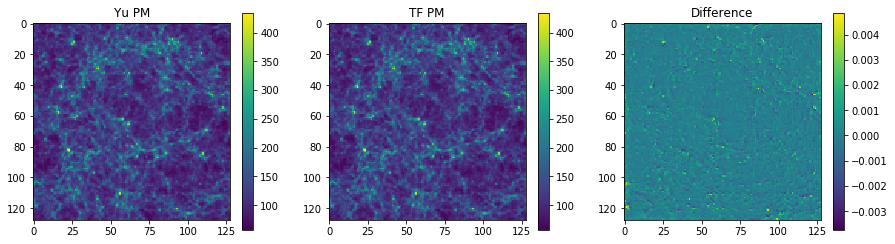

In [40]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Yu PM')
im = ax[1].imshow(tfmeshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('TF PM')
im = ax[2].imshow((meshpm-tfmeshpm)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
